# Time Series Analysis with Long Short-Term Memory Neural Networks

In this notebook, we're going to utilize LSTM neural networks to help with time series forecasting.  While LSTMs were primarily used in Natural Language Processing and Speech Recognition, because they rely on past information to contextualize current information.  This is similar to how Time Series Analysis uses the values of the past to predict current and future values.  This similarity is the reason that LSTMs have become more popular in Time Series modeling and forecasting. 

We're going to measure how accurately our model can predict data that is a week out.

Before we get modeling, however, our data needs to be in a certain format before we feed it into our network.  Time for some more preprocessing!

# Preprocessing

In [31]:
# Importing libraries and dataset

import warnings
warnings.filterwarnings('ignore')

import os
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Check out the dataset
print(f'Test dates: {df.date.min()} to {df.date.max()}')

# Set to index
df = df.set_index('date')
df = df.asfreq('D')

df.head()

Test dates: 2020-01-22 00:00:00 to 2020-10-03 00:00:00


,AK_positiveIncrease,AL_positiveIncrease,AR_positiveIncrease,AS_positiveIncrease,AZ_positiveIncrease,CA_positiveIncrease,CO_positiveIncrease,CT_positiveIncrease,DC_positiveIncrease,DE_positiveIncrease,...,TN_positiveIncrease,TX_positiveIncrease,UT_positiveIncrease,VA_positiveIncrease,VI_positiveIncrease,VT_positiveIncrease,WA_positiveIncrease,WI_positiveIncrease,WV_positiveIncrease,WY_positiveIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


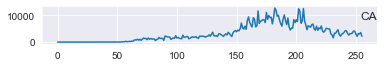

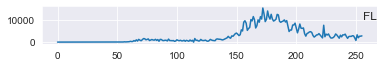

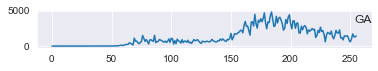

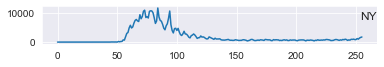

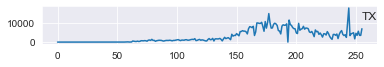

In [3]:
top_5 = df[['CA_positiveIncrease', 'FL_positiveIncrease', 
            'GA_positiveIncrease', 'NY_positiveIncrease', 
            'TX_positiveIncrease']]

# Rename columns for ease of use
top_5 = top_5.rename(columns={'CA_positiveIncrease':'CA', 
                              'FL_positiveIncrease':'FL', 
                              'GA_positiveIncrease':'GA', 
                              'NY_positiveIncrease':'NY', 
                              'TX_positiveIncrease':'TX'})
# Plotting
groups = range(len(top_5.columns))
values = top_5.values
col = 1
#fig = plt.figure(figsize=(20, 10))
for group in groups:
    plt.subplot(len(groups), 1, col)
    plt.plot(values[:, group])
    plt.title(top_5.columns[group], y=0.5, loc='right')
    col += 1
    plt.show();

## Converting from Time Series to Supervised Learning Problem
This might seem like a weird concept since Time Series Analysis IS a form of supervised learning, so let's clarify this.  In traditional ARMA and (S)ARIMA modeling, the data needs to be in a format of a series with the dates in the index (for easy manipulation) and the values in a column.  This means that your data is in a sequence.  For our LSTM to work, we need to change the data from a sequence to input (`X`) and output (`y`) pairs, where `X` is "today" (`t`) and `y` is equal to "tomorrow" (`t + 1`).  To do this, we'll need to scale our data and convert them from an array of values to a matrix.

### Scaling Data

A single LSTM layer will utilize a "forget gate", an "input gate", and an "output gate". Each of these gates use sigmoid function in one way or another.  Because of this, we're going to want to put our data on a scale of 0 to 1. We also want to normalize this data simply because the range of values is so large.  Each state has a minimum of 0 and will eventually have values in the thousands and ten thousands.  This scaling also helps to make our data more stationary, in a sense.


### Train, Validation, and Test Splits

Once we've scaled the data we'll split up the sets so that the validation has 14 days, and the test set has 7 days.  This should be a good split considering that the seasonality of the time series seems to be weekly across the board.

In [14]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test




In [15]:
ca_train, ca_val, ca_test = preprocess_data(df, 'CA_positiveIncrease')

print(f"Train has {len(ca_train)} values")
print(f"Validation has {len(ca_val)} values")
print(f"Test has {len(ca_test)} values")

Train has 235 values
Validation has 7 values
Test has 14 values


Now that we have a function to efficiently split our data, let's make another function that will divide each of our sets into a arrays of `X` and `y` values.

In [16]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)


In [24]:
look_back = 1

X_train, y_train = create_dataset(ca_train, look_back)
X_val, y_val = create_dataset(ca_val, look_back)
X_test, y_test = create_dataset(ca_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping


model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False)

model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 3ms/step - loss: 0.1314 - val_loss: 0.0519
Epoch 2/500
233/233 [==============================] - 0s 69us/step - loss: 0.1225 - val_loss: 0.0455
Epoch 3/500
233/233 [==============================] - 0s 69us/step - loss: 0.1143 - val_loss: 0.0394
Epoch 4/500
233/233 [==============================] - 0s 73us/step - loss: 0.1058 - val_loss: 0.0339
Epoch 5/500
233/233 [==============================] - 0s 77us/step - loss: 0.0988 - val_loss: 0.0288
Epoch 6/500
233/233 [==============================] - 0s 60us/step - loss: 0.0915 - val_loss: 0.0242
Epoch 7/500
233/233 [==============================] - 0s 73us/step - loss: 0.0852 - val_loss: 0.0201
Epoch 8/500
233/233 [==============================] - 0s 68us/step - loss: 0.0800 - val_loss: 0.0164
Epoch 9/500
233/233 [==============================] - 0s 86us/step - loss: 0.0739 - val_loss: 0.0132
Epoch 10/500
233/233 [=================

In [26]:
from sklearn.metrics import mean_absolute_error as MAE

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train[0], train_predict[:,0]))

print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train[0], 
                                                   train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test[0], test_predict[:,0]))

print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test[0], 
                                                  test_predict[:,0])))

Train Mean Absolute Error: 2083.253978549155
Train Root Mean Squared Error: 2477.120052776977
Test Mean Absolute Error: 502.4012858072918
Test Root Mean Squared Error: 627.7624159368437


### Convert from Time Series to Supervised Task
Our next step is to 

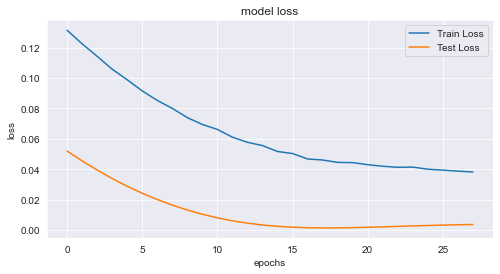

In [27]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [28]:
y_test

array([[3294., 2630., 3146., 3170., 3400., 4197., 4071., 2955., 2162.,
        3200., 3062., 3590.]])

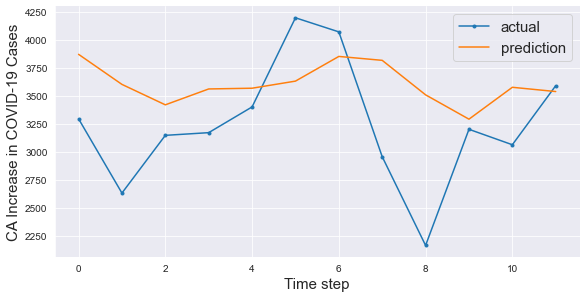

In [30]:
aa=[x for x in range(12)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:12], '-', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('CA Increase in COVID-19 Cases', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### Splitting Sets into Folders
Now that we have the data split into sets, we're going to split these sets into separate folders. These folders will contain pandas dataframes of the original values, as well as the values for the lags time frame we want to consider when predicting our target number of days in the future.  This way we can meet the shape requirements for the neural network.  We'll also be able to make modeling more efficient by having the model look through the data 1 row at a time, as opposed to the whole dataset.  



In [13]:
# create y_test
y_test = pd.read_csv('states_test.csv')

y_test = y_test[['date', 'state', 'positiveIncrease', 
                         'negativeIncrease', 'total', 
                         'totalTestResultsIncrease']]

y_test['date'] = pd.to_datetime(y_test['date'], format='%Y%m%d')

